In [ ]:
# Loading Libraries in The Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report,roc_curve, roc_auc_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import re

## Loading Dataset

In [ ]:
df_past=pd.read_csv('NEO Earth Close Approaches_past.csv')
df_past.head()

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,509352 (2007 AG),1900-Jan-04 22:25 ± 00:02,0.00963,0.00962,8.69,8.65,20.2,250 m - 550 m,2
1,(2014 SC324),1900-Jan-11 01:07 ± 00:18,0.03997,0.03991,10.65,10.65,24.4,35 m - 79 m,0
2,(2012 UK171),1900-Jan-12 23:07 ± 00:13,0.04982,0.04950,7.16,7.15,24.4,35 m - 77 m,0
3,(2024 BW1),1900-Jan-25 19:29 ± 4_11:16,0.03798,0.01013,6.34,6.33,25.1,25 m - 56 m,0
4,4660 Nereus (1982 DB),1900-Jan-29 18:09 ± 00:35,0.02080,0.02077,5.54,5.52,18.8,0.33±0.05 km,2


In [ ]:
# Load the dataset
df_future=pd.read_csv('NEO_future.csv')
df_future.head()

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,(2024 KA1),2024-Jun-07 11:06 ± < 00:01,0.01255,0.01254,8.32,8.30,25.3,23 m - 51 m,0.0
1,(2024 LA),2024-Jun-07 22:20 ± < 00:01,0.01204,0.01197,18.28,18.27,25.8,18 m - 41 m,0.0
2,(2024 LC),2024-Jun-08 12:18 ± < 00:01,0.03137,0.03122,8.71,8.70,25.6,20 m - 45 m,0.0
3,(2024 CR9),2024-Jun-11 00:03 ± < 00:01,0.04924,0.04924,7.38,7.37,19.5,340 m - 760 m,1.0
4,(2024 LD),2024-Jun-11 11:06 ± 00:02,0.03093,0.03067,10.68,10.67,26.1,16 m - 36 m,0.0


In [ ]:
df=pd.concat([df_past,df_future],axis=0)
df=df.reset_index(drop=True)

In [ ]:
#data.column method returns an array of columns list.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29918 entries, 0 to 29917
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    29918 non-null  object 
 1   Close-Approach (CA) Date  29918 non-null  object 
 2   CA DistanceNominal (au)   29918 non-null  float64
 3   CA DistanceMinimum (au)   29918 non-null  float64
 4   V relative(km/s)          29918 non-null  float64
 5   V infinity(km/s)          29910 non-null  float64
 6   H(mag)                    29916 non-null  float64
 7   Diameter                  29916 non-null  object 
 8   Rarity                    29916 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.1+ MB


# data cleaning

In [ ]:
df=df.dropna(axis=0)

In [ ]:
# Function to parse diameter values
def parse_diameter(diameter):
    range_match = re.match(r'(\d+\.?\d*)\s*m\s*-\s*(\d+\.?\d*)\s*m', diameter)
    if range_match:
        min_diameter = float(range_match.group(1))
        max_diameter = float(range_match.group(2))
        return (min_diameter + max_diameter) / 2

    uncertainty_match = re.match(r'(\d+\.?\d*)±(\d+\.?\d*)\s*km', diameter)
    if uncertainty_match:
        value = float(uncertainty_match.group(1))
        return value * 1000  # Convert km to meters

    single_value_match = re.match(r'(\d+\.?\d*)\s*km', diameter)
    if single_value_match:
        value = float(single_value_match.group(1))
        return value * 1000  # Convert km to meters

    single_value_match = re.match(r'(\d+\.?\d*)\s*m', diameter)
    if single_value_match:
        value = float(single_value_match.group(1))
        return value

    return np.nan


In [ ]:

# Apply the parsing function
df['Diameter_Parsed'] = df['Diameter'].apply(parse_diameter)

# Handle missing values
df['Diameter_Parsed'].fillna(df['Diameter_Parsed'].mean(), inplace=True)



In [ ]:
# Function to parse the close approach date and time
def parse_ca_date(ca_date_str):
    # Split the string on '±' and take the first part (date and time)
    date_time_str = ca_date_str.split('±')[0].strip()
    # Parse the date and time
    return pd.to_datetime(date_time_str, format='%Y-%b-%d %H:%M', errors='coerce')

# Apply the parsing function to the 'Close-Approach (CA) Date' column
df['CA_Date_Parsed'] = df['Close-Approach (CA) Date'].apply(parse_ca_date)


In [ ]:
# Extract components from the datetime
df['CA_Year'] = df['CA_Date_Parsed'].dt.year
df['CA_Month'] = df['CA_Date_Parsed'].dt.month
df['CA_Day'] = df['CA_Date_Parsed'].dt.day
df['CA_Hour'] = df['CA_Date_Parsed'].dt.hour
df['CA_Minute'] = df['CA_Date_Parsed'].dt.minute
df=df.drop(['CA_Date_Parsed','Close-Approach (CA) Date','Object','Diameter'],axis=1)

In [ ]:
# Function to categorize Rarity
def categorize_rarity(rarity):
    if rarity in [0.0, 1.0]:
        return 'Frequent'  # Frequent
    elif rarity in [2.0]:
        return 'Moderate'  # Moderate
    elif rarity in [3.0,4.0, 5.0, 6.0]:
        return 'Rare'  # Rare

# Apply categorization
df['Rarity'] = df['Rarity'].apply(categorize_rarity)

In [ ]:
df['Rarity'].value_counts()

Rarity
Frequent    27208
Moderate     2292
Rare          408
Name: count, dtype: int64

In [ ]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29908 entries, 0 to 29917
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CA DistanceNominal (au)  29908 non-null  float64
 1   CA DistanceMinimum (au)  29908 non-null  float64
 2   V relative(km/s)         29908 non-null  float64
 3   V infinity(km/s)         29908 non-null  float64
 4   H(mag)                   29908 non-null  float64
 5   Rarity                   29908 non-null  object 
 6   Diameter_Parsed          29908 non-null  float64
 7   CA_Year                  29908 non-null  int32  
 8   CA_Month                 29908 non-null  int32  
 9   CA_Day                   29908 non-null  int32  
 10  CA_Hour                  29908 non-null  int32  
 11  CA_Minute                29908 non-null  int32  
dtypes: float64(6), int32(5), object(1)
memory usage: 2.4+ MB


In [ ]:
# Describes the dataset
df.describe()

,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter_Parsed,CA_Year,CA_Month,CA_Day,CA_Hour,CA_Minute
count,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000
mean,0.030738,0.026819,10.959227,10.943645,24.087298,125.888822,2043.046977,6.574696,15.632573,11.514779,29.362345
std,0.012530,0.013608,5.566818,5.574213,2.433403,225.067609,70.831207,3.546217,8.852800,6.927949,17.287075
min,0.000210,0.000000,0.390000,0.170000,14.100000,1.090000,1900.000000,1.000000,1.000000,0.000000,0.000000
25%,0.021150,0.015928,7.000000,6.980000,22.600000,32.000000,2006.000000,3.000000,8.000000,6.000000,14.000000
50%,0.032160,0.027490,9.840000,9.830000,24.600000,51.500000,2025.000000,6.000000,16.000000,11.000000,30.000000
75%,0.041440,0.038300,13.820000,13.820000,25.600000,129.500000,2092.000000,10.000000,23.000000,18.000000,44.000000
max,0.050000,0.050000,41.970000,41.970000,33.000000,7000.000000,2200.000000,12.000000,31.000000,23.000000,59.000000


# Exploratory Data Analysis

## Checking For Null Values

In [ ]:
# Checking for null values in the dataset
nulls = pd.DataFrame(df.isnull().sum(), columns=['Total'])
nulls['Total Percentage'] = df.isnull().sum() / len(df) * 100
nulls

,Total,Total Percentage
CA DistanceNominal (au),0,0.0
CA DistanceMinimum (au),0,0.0
V relative(km/s),0,0.0
V infinity(km/s),0,0.0
H(mag),0,0.0
Rarity,0,0.0
Diameter_Parsed,0,0.0
CA_Year,0,0.0
CA_Month,0,0.0
CA_Day,0,0.0


<Axes: >

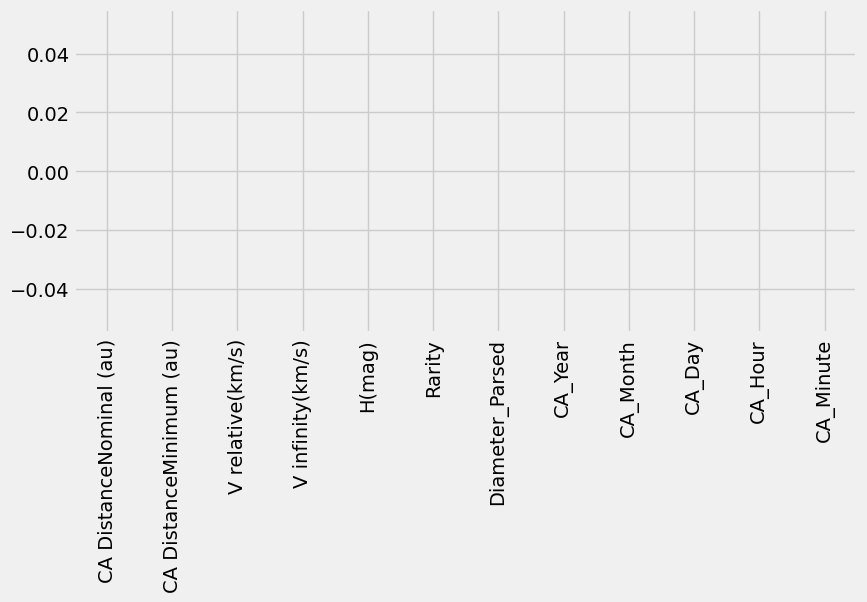

In [ ]:
# Plotting Graph of Missing Values
Miss_val = df.isna().sum()/ len(df) * 100
Miss_val.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(9,4))
Miss_val.plot.bar()

## Class Distribution

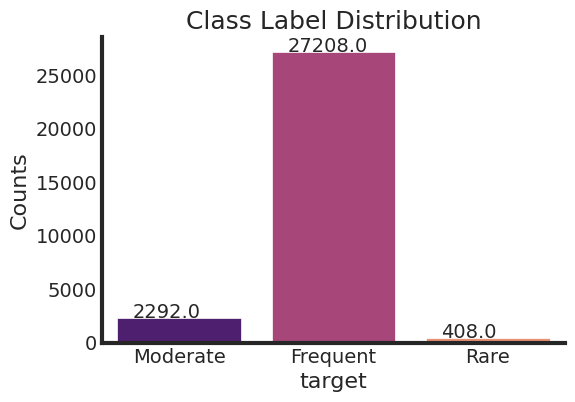

In [ ]:
# Seaborn Library
sns.set_style("white")
g = sns.catplot(x="Rarity", data=df, kind="count",
                   palette="magma", height=4, aspect=1.5)
g.ax.xaxis.set_label_text("target",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Counts", fontdict= {'size':16})
g.ax.set_title("Class Label Distribution",fontdict= {'size':18})
# to get the counts on the top heads of the bar
for p in g.ax.patches:
    g.ax.annotate((p.get_height()), (p.get_x()+0.1, p.get_height()+20))

## Distribution of Numerical Attributes

In [ ]:
numerical_features = ['CA DistanceNominal (au)', 'CA DistanceMinimum (au)', 'V relative(km/s)',
                      'V infinity(km/s)', 'H(mag)', 'Diameter_Parsed', 'CA_Year', 'CA_Month',
                      'CA_Day', 'CA_Hour', 'CA_Minute']

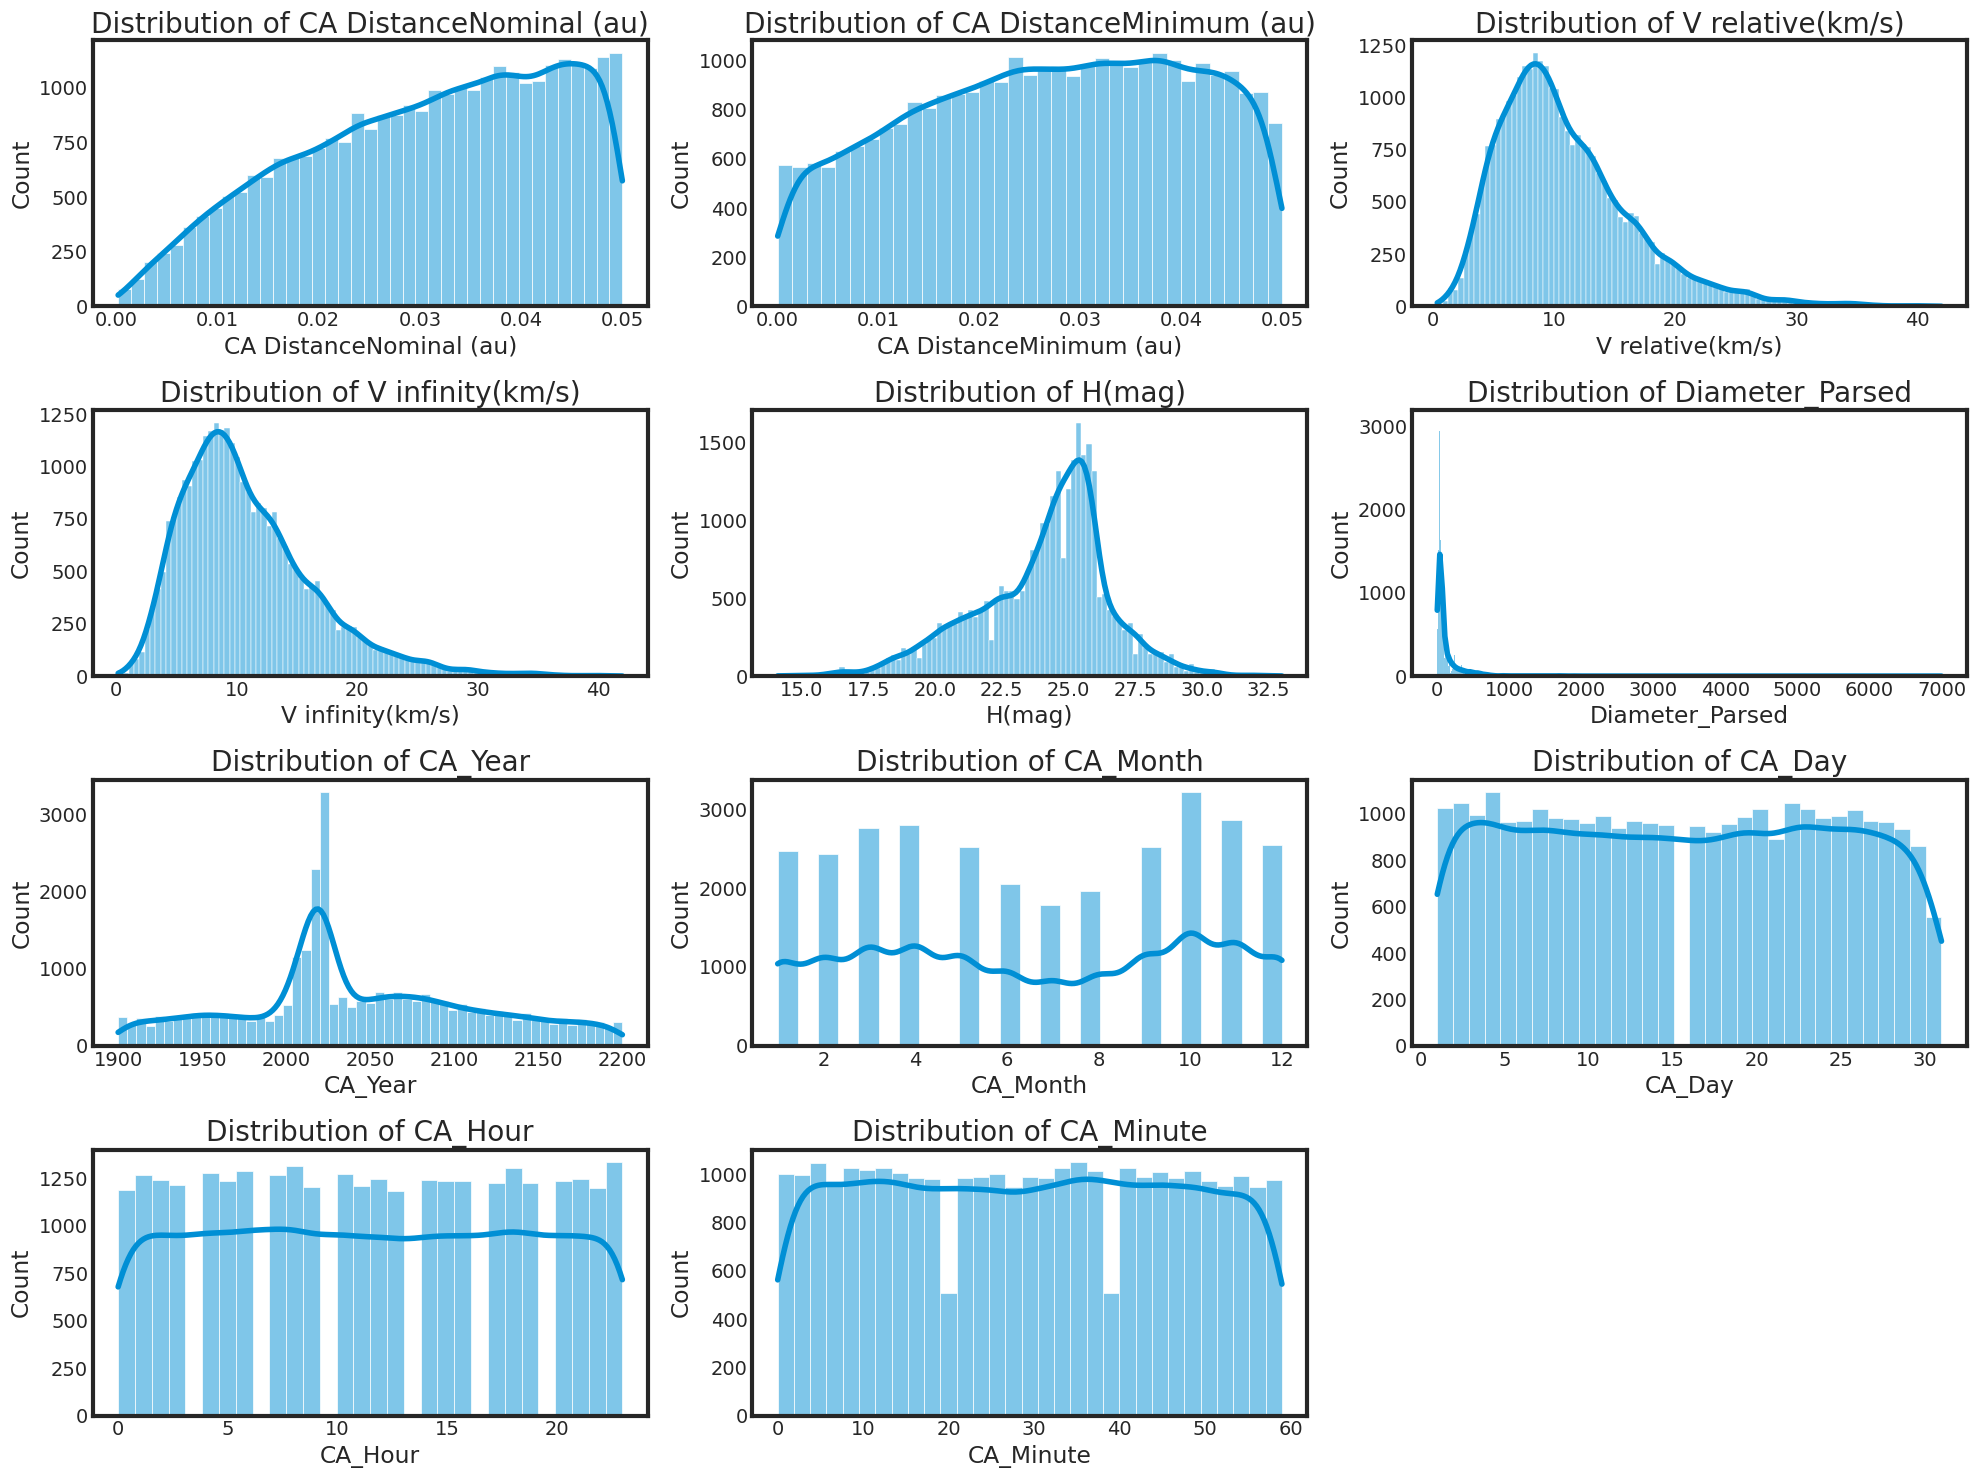

In [ ]:

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# heatmap correlation plot

Text(0.5, 1.0, 'Correlation Heatmap')

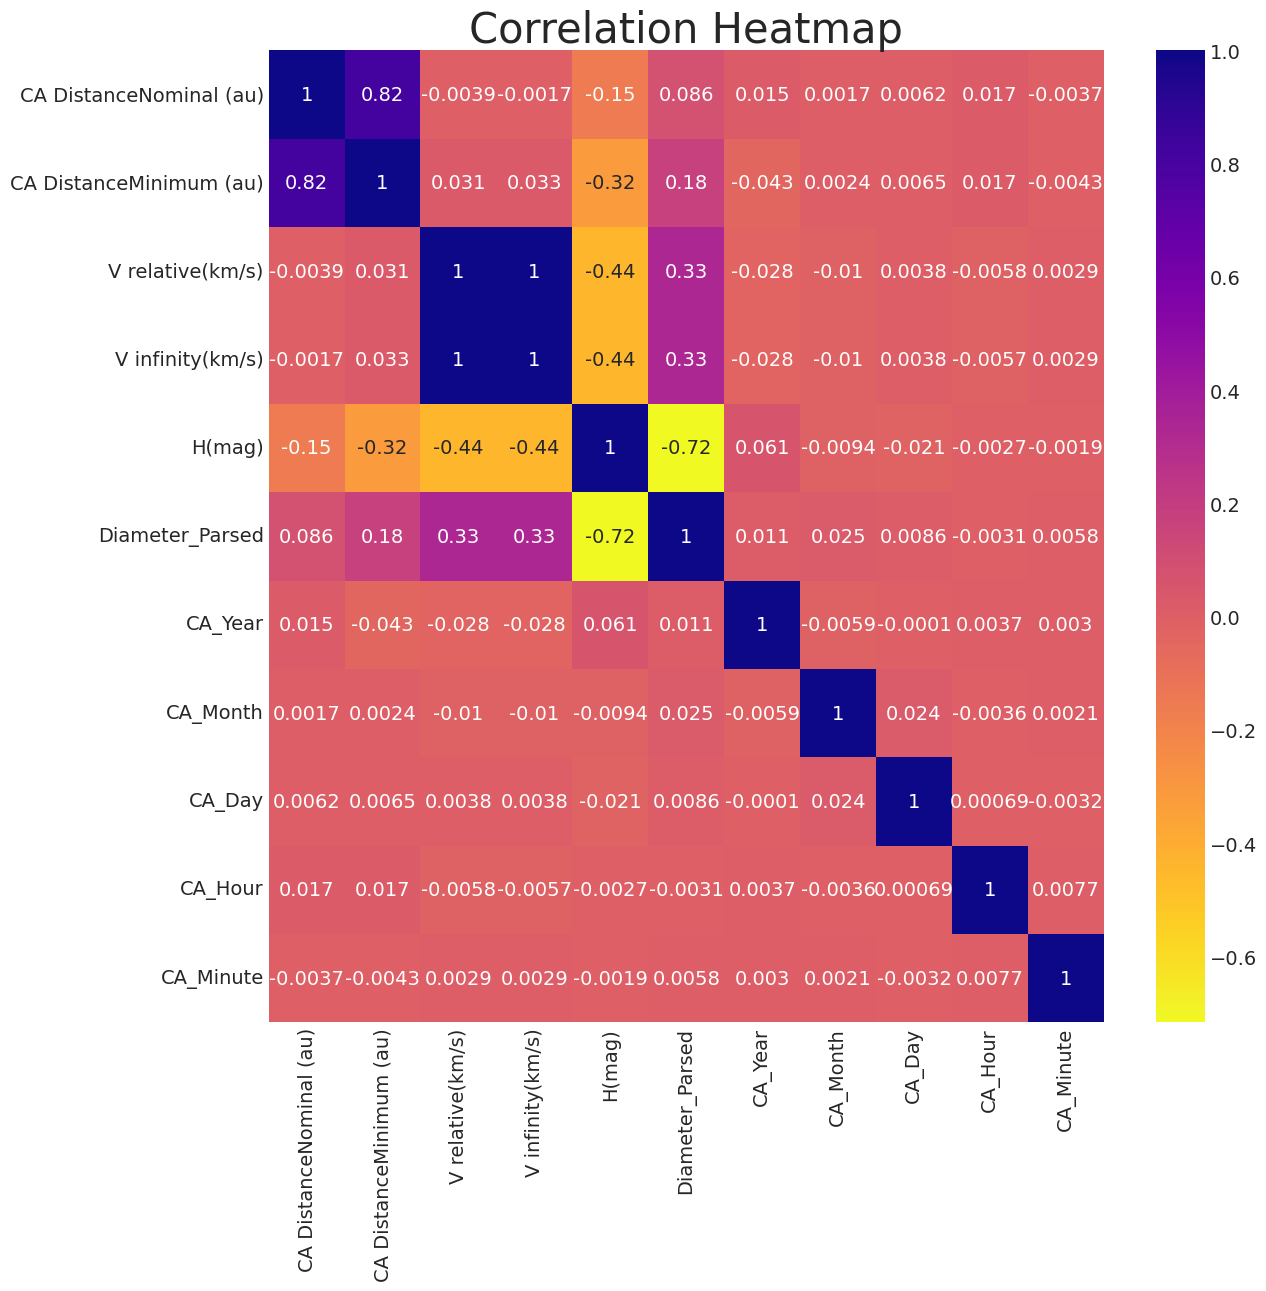

In [ ]:
corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap="plasma_r")
plt.title('Correlation Heatmap', fontsize=30)

# box plot of all features with hue as rarity

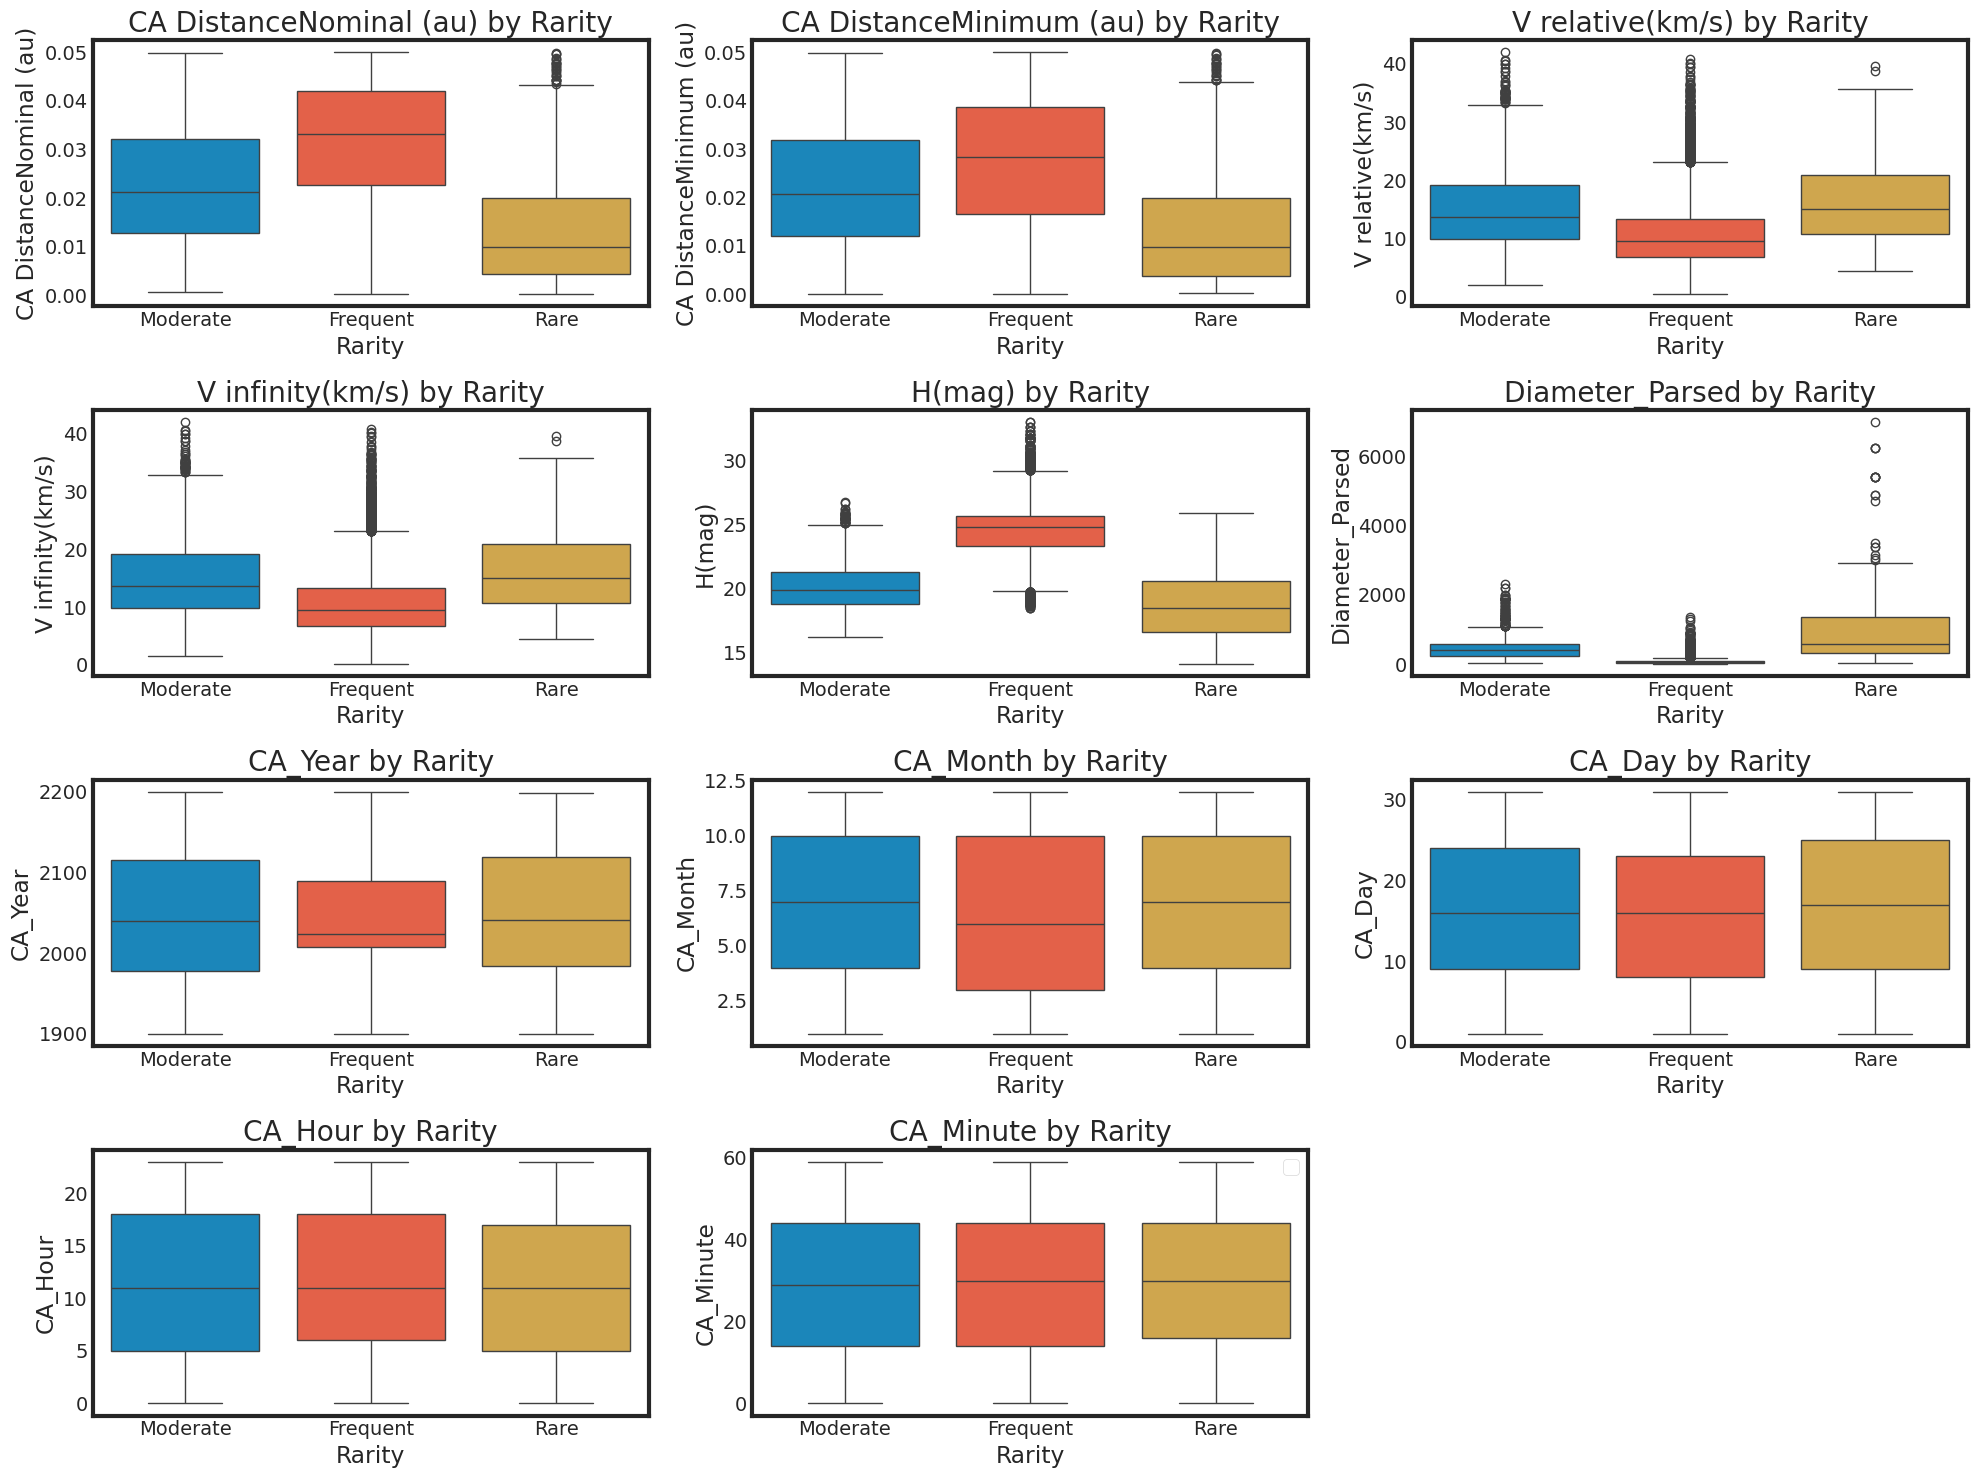

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Rarity', y=feature, data=df, hue='Rarity')
    plt.title(f'{feature} by Rarity')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# data preprocessing

In [ ]:
#defining inputs and outputs as X and y respectively
X = df.drop(['Rarity'], axis=1)
y = df['Rarity']

# Encoding object type features using label encoder

In [ ]:
# Encoding of categorical features
X=pd.get_dummies(X)

# Splitting The Dataset for Testing & Training

In [ ]:
# Splitting The Dataset for Testing & Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)